In [1]:
from elasticsearch import Elasticsearch
es = Elasticsearch("http://localhost:9200")
print(es.info())

{'name': '3a728dd319ba', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'WO2zj9DLSoaLWbLwQ2v37A', 'version': {'number': '8.15.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179', 'build_date': '2024-08-05T10:05:34.233336849Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [2]:
import os
import pandas as pd

path = "./dataset/bbc"
data = []
id_counter = 0

for category in os.listdir(path):
    category_path = os.path.join(path, category)

    if os.path.isdir(category_path):

        for filename in os.listdir(category_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(category_path, filename)

                with open(file_path, "r", encoding="latin1") as f:
                    text = f.read().strip()

                lines = text.split("\n")
                title = lines[0].strip() if len(lines) > 0 else ""
                full_text = " ".join(lines[1:]).strip() if len(lines) > 1 else title

                data.append({
                    "id": id_counter,
                    "category": category,
                    "title": title,
                    "text": full_text
                })

                id_counter += 1

df = pd.DataFrame(data, columns=["id","category","title","text"])
print(df.shape)
print(df.head(10))

(2225, 4)
   id category                             title  \
0   0     tech  Looks and music to drive mobiles   
1   1     tech   Hi-tech posters guide commuters   
2   2     tech      Xbox power cable 'fire fear'   
3   3     tech  Games win for Blu-ray DVD format   
4   4     tech  PC photo printers challenge pros   
5   5     tech  Software watching while you work   
6   6     tech    Online commons to spark debate   
7   7     tech  Apple sues to stop product leaks   
8   8     tech           Broadband soars in 2004   
9   9     tech  Pandas benefit from wireless net   

                                                text  
0  Mobile phones are still enjoying a boom time i...  
1  Interactive posters are helping Londoners get ...  
2  Microsoft has said it will replace more than 1...  
3  The next-generation DVD format Blu-ray is winn...  
4  Home printed pictures can be cheaper and highe...  
5  Software that can not only monitor every keyst...  
6  Online communities set up by 

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df['category']
)

print("Tamanho do treino:", len(train_df))
print("Tamanho do teste:", len(test_df))


Tamanho do treino: 1557
Tamanho do teste: 668


In [4]:
!pip install tqdm

In [5]:
from tqdm import tqdm

index_name = "bbc_articles"

if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

mapping = {
    "mappings":{
        "properties": {
            "title": {"type":"text"},
            "text": {"type":"text"},
            "category": {"type":"keyword"}
        }
    }
}

es.indices.create(index=index_name, body=mapping)

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    doc = {
        "title": row["title"],
        "text": row["text"],
        "category": row["category"]
    }
    es.index(index=index_name, id=int(row["id"]), document=doc)

100%|██████████| 1557/1557 [00:13<00:00, 114.44it/s]


In [6]:
# Exemplo de uma consulta em nossos documentos indexados. Utiliza o BM-25 para realizar a busca (lexical search).

query = {
    "query": {
        "match": {
            "text": "government policy economy"
        }
    }
}

res = es.search(index=index_name, body=query)
for hit in res['hits']['hits']:
    print(hit['_score'], "->", hit['_source']['title'])

9.9581375 -> Markets signal Brazilian recovery
9.724558 -> Japan economy slides to recession
9.535395 -> Japanese growth grinds to a halt
9.44218 -> Brazil jobless rate hits new low
8.547661 -> Parties warned over 'grey vote'
8.499299 -> BBC poll indicates economic gloom
7.894039 -> US trade deficit widens sharply
7.822341 -> Newest EU members underpin growth
7.681158 -> 'Strong dollar' call halts slide
7.6731896 -> Blair backs 'pre-election budget'


In [26]:
queries = {
    "business": [
        "latest stock market trends",
        "company profits and earnings reports",
        "impact of inflation on global economy",
        "business mergers and acquisitions news",
        "rise of startups in finance sector",
        "oil prices and economic growth"
    ],
    "entertainment": [
        "new movie releases this month",
        "celebrity awards and red carpet events",
        "top streaming series of the year",
        "music festivals and live performances",
        "film reviews from critics",
        "box office hits and records"
    ],
    "politics": [
        "government election campaign promises",
        "international relations and diplomacy",
        "new legislation passed by parliament",
        "political debates on climate change",
        "public opinion on government policies",
        "european union policy changes"
    ],
    "sport": [
        "football world cup latest scores",
        "tennis grand slam results",
        "athletes preparing for olympic games",
        "transfer news in premier league",
        "team rankings in international cricket",
        "basketball championship finals highlights"
    ],
    "tech": [
        "latest smartphone innovations",
        "artificial intelligence in healthcare",
        "cybersecurity and data breaches",
        "new software development frameworks",
        "future of quantum computing",
        "robotics and automation in industry"
    ]
}

def overlap_count(query,text):
    q_terms = set(query.lower().split())
    t_terms = set(text.lower().split())
    return len(q_terms & t_terms)

ltr_data = []
query_id = 0

for category, query_list in queries.items():
    for query_text in query_list:
        query_id += 1

        query_body = {
            "size":50,
            "query":{
                "multi_match": {
                    "query": query_text,
                    "fields":["title^2","text"]
                }
            }
        }

        res = es.search(index=index_name, body=query_body)

        for hit in res["hits"]["hits"]:
            doc_id = hit["_id"]
            doc = hit["_source"]
            
            score = hit["_score"]
            overlap_title = overlap_count(query_text,doc["title"])
            overlap_text = overlap_count(query_text,doc["text"])
            same_category = 1 if doc["category"] == category else 0
            relevance = 1 if doc["category"] == category else 0

            
            ltr_data.append({
                "query_id": query_id,
                "query_text": query_text,
                "doc_id": doc_id,
                "bm25_score":score,
                "query_overlap_title": overlap_title,
                "query_overlap_text": overlap_text,
                "same_category": same_category,
                "relevance": relevance
            })

ltr_df = pd.DataFrame(ltr_data)
print(ltr_df.head(10))
ltr_df.to_csv("ltr_dataset.csv",index=False)

   query_id                  query_text doc_id  bm25_score  \
0         1  latest stock market trends    188   13.169068   
1         1  latest stock market trends    342   13.169068   
2         1  latest stock market trends    651   10.705631   
3         1  latest stock market trends    611   10.473111   
4         1  latest stock market trends    735   10.232143   
5         1  latest stock market trends    357   10.232143   
6         1  latest stock market trends    134   10.232143   
7         1  latest stock market trends    496    9.555423   
8         1  latest stock market trends    559    9.482377   
9         1  latest stock market trends    204    9.482377   

   query_overlap_title  query_overlap_text  same_category  relevance  
0                    1                   1              0          0  
1                    1                   1              0          0  
2                    0                   3              1          1  
3                    0           

In [8]:
!pip install lightgbm
!pip install scikit_learn

In [40]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import ndcg_score

X = ltr_df[['bm25_score', 'query_overlap_title', 'query_overlap_text']]
y = ltr_df['relevance']

num_queries = ltr_df['query_id'].nunique()
docs_per_query = 50

group_sizes = [docs_per_query] * num_queries

train_data = lgb.Dataset(X, label=y, group=group_sizes)

params = {
    "objective":"lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at":[10],
    "learning_rate": 0.05,
    "num_leaves":31,
    "min_data_in_leaf": 20,
    "verbose": -1
}

model = lgb.train(params, train_data, num_boost_round=200)
model.save_model("ltr_model.txt")

In [38]:
index_name = "bbc_articles_test"

if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

mapping = {
    "mappings": {
        "properties": {
            "title": {"type":"text"},
            "text": {"type": "text"},
            "category": {"type": "keyword"}
        }
    }
}

es.indices.create(index=index_name, body=mapping)

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    doc = {
        "title": row["title"],
        "text": row["text"],
        "category": row["category"]
    }

    es.index(index=index_name, id=int(row["id"]), document=doc)

100%|██████████| 668/668 [00:04<00:00, 152.00it/s]


In [39]:
ltr_data_test = []
query_id = 0

for category, query_list in queries.items():
    for query_text in query_list:
        query_id += 1

        query_body = {
            "size":50,
            "query":{
                "multi_match": {
                    "query": query_text,
                    "fields":["title^2","text"]
                }
            }
        }

        res = es.search(index=index_name, body=query_body)

        for hit in res["hits"]["hits"]:
            doc_id = hit["_id"]
            doc = hit["_source"]
            
            score = hit["_score"]
            overlap_title = overlap_count(query_text,doc["title"])
            overlap_text = overlap_count(query_text,doc["text"])
            same_category = 1 if doc["category"] == category else 0
            relevance = 1 if doc["category"] == category else 0

            
            ltr_data_test.append({
                "query_id": query_id,
                "query_text": query_text,
                "doc_id": doc_id,
                "bm25_score":score,
                "query_overlap_title": overlap_title,
                "query_overlap_text": overlap_text,
                "same_category": same_category,
                "relevance": relevance
            })

ltr_df_test = pd.DataFrame(ltr_data_test)
print(ltr_df_test.head(10))
ltr_df_test.to_csv("ltr_dataset_test.csv",index=False)

   query_id                  query_text doc_id  bm25_score  \
0         1  latest stock market trends    488   21.279842   
1         1  latest stock market trends    831   13.123344   
2         1  latest stock market trends   1882   11.447304   
3         1  latest stock market trends    709    9.832540   
4         1  latest stock market trends    900    9.476984   
5         1  latest stock market trends   1075    9.112797   
6         1  latest stock market trends    704    9.112797   
7         1  latest stock market trends    237    9.112797   
8         1  latest stock market trends    891    9.011817   
9         1  latest stock market trends     17    8.916468   

   query_overlap_title  query_overlap_text  same_category  relevance  
0                    2                   0              1          1  
1                    0                   2              1          1  
2                    1                   0              0          0  
3                    1           

 NDCG@10 médio por query (BM25): 0.6158
 NDCG@10 médio por query (LTR):  0.6576
 Ganho relativo: +0.0418


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

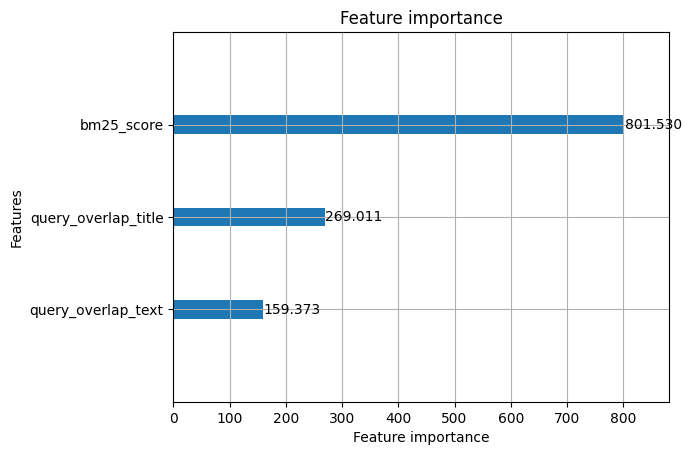

In [46]:
features_cols = ['bm25_score','query_overlap_title','query_overlap_text']
X_test = ltr_df_test[features_cols]
y_test = ltr_df_test['relevance']
query_ids = ltr_df_test['query_id']

y_pred_ltr = model.predict(X_test)
ndcg_ltr_list, ndcg_bm25_list = [],[]

for qid in sorted(ltr_df_test['query_id'].unique()):
    mask = (query_ids == qid)
    y_true_q = y_test[mask].values
    y_pred_q = y_pred_ltr[mask]
    y_bm25_q = ltr_df_test.loc[mask, 'bm25_score'].values

    ndcg_ltr = ndcg_score([y_true_q], [y_pred_q], k=10)
    ndcg_bm25 = ndcg_score([y_true_q], [y_bm25_q], k=10)

    ndcg_ltr_list.append(ndcg_ltr)
    ndcg_bm25_list.append(ndcg_bm25)

mean_ndcg_ltr = np.mean(ndcg_ltr_list)
mean_ndcg_bm25 = np.mean(ndcg_bm25_list)
gain = mean_ndcg_ltr - mean_ndcg_bm25

print(f" NDCG@10 médio por query (BM25): {mean_ndcg_bm25:.4f}")
print(f" NDCG@10 médio por query (LTR):  {mean_ndcg_ltr:.4f}")
print(f" Ganho relativo: +{gain:.4f}")

lgb.plot_importance(model, importance_type="gain", max_num_features=10)